In [1]:
import keras
import tensorflow as tf
import keras.backend as K
from keras.models import Model
import warnings
warnings.filterwarnings("ignore")

from models import matting_net

def convert_checkpoint_into_tflite(h5_path=None,
                                   output_path=None,
                                   android=True):
    if android:
        model = matting_net((256,256,4), android=True)
        
    else:
        model = matting_net((256,256,3), android=False)
    # model 명 과 상세사항 정리해두기 
    model.load_weights(h5_path, by_name=True)

    input_names = [node.op.name for node in model.inputs]
    output_names = [node.op.name for node in model.outputs]
    print(input_names)
    print(output_names)

    sess = K.get_session()
    converter = tf.lite.TFLiteConverter.from_session(sess, model.inputs, model.outputs)

    tflite_model = converter.convert()
    open(output_path, "wb").write(tflite_model)
    print("tflite successfully built")
    
    return model

Using TensorFlow backend.
/Users/hyunkim/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/hyunkim/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/hyunkim/.pyenv/versions/anaconda3-5.3.0/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16",

In [2]:
model = convert_checkpoint_into_tflite(h5_path="./trained_models/20191211/10_sig_mat.h5",
                                       output_path="./tflite/10_sig_mat.tflite", 
                                       android=True)






['input_1']
['output/Sigmoid']
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 166 variables.
INFO:tensorflow:Converted 166 variables to const ops.
tflite successfully built


## Model output test

In [3]:
import numpy as np 
import cv2
import matplotlib.pyplot as plt

img = cv2.imread("./dataset/selfie/training/00694.png", cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (256,256))
img = np.concatenate([img, np.ones((256,256,1))], axis=-1)[np.newaxis,:,:,:]
img = img / 255.

mask = cv2.imread("./dataset/selfie/training/00694_matte.png", cv2.IMREAD_GRAYSCALE)
mask = cv2.resize(mask, (256,256))

pred = model.predict(img)

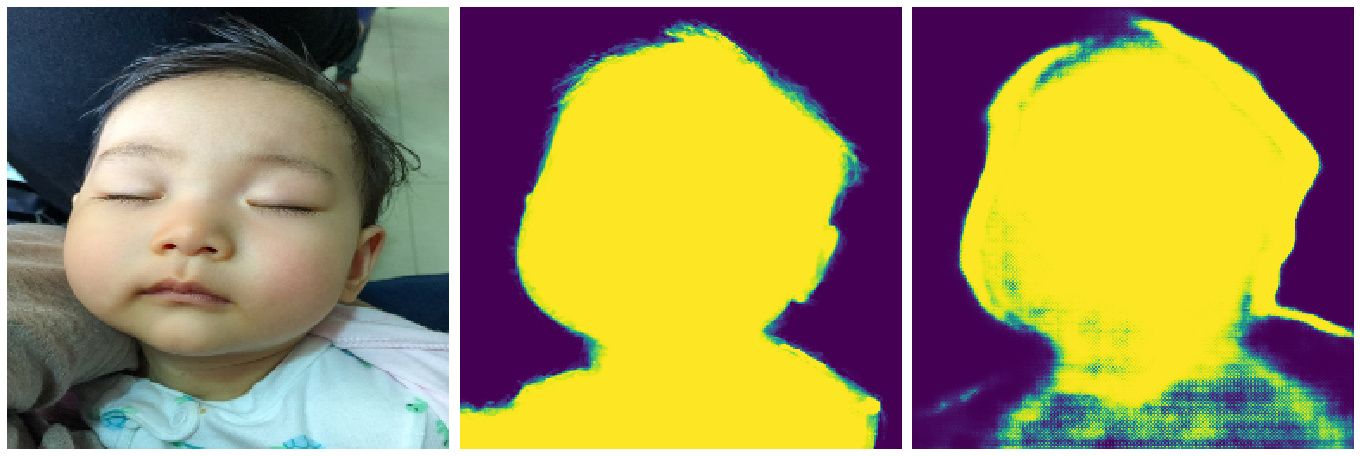

In [4]:
plt.figure(figsize=(19,7))
plt.subplot(131)
plt.imshow(img.squeeze(0)[:,:,:3])
plt.axis("off")

plt.subplot(132)
plt.imshow(mask)
plt.axis("off")

plt.subplot(133)
plt.imshow(pred.squeeze(0).squeeze(-1))
plt.axis("off")

plt.tight_layout()
plt.show()